In [1]:
%matplotlib inline
import numpy as np
import tensorflow as tf
import os
import matplotlib.pyplot as plt

from PIL import Image

from utils import label_map_util
from utils import visualization_utils as vis_util

In [2]:
MODEL_NAME     = 'ssd_mobilenet_v1_coco_11_06_2017'
PATH_TO_CKPT   = MODEL_NAME + '/frozen_inference_graph.pb'
PATH_TO_LABELS = os.path.join('data', 'mscoco_label_map.pbtxt')
NUM_CLASSES    = 90

In [3]:
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name = '')

In [4]:
label_map      = label_map_util.load_labelmap(PATH_TO_LABELS)
categories     = label_map_util.convert_label_map_to_categories(label_map, max_num_classes = NUM_CLASSES, use_display_name = True)
category_index = label_map_util.create_category_index(categories)

In [5]:
def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    data = image.getdata()
    return np.array(data).reshape((im_height, im_width, 3)).astype(np.uint8)

In [6]:
def result_to_vehicle_number(boxes, classes, scores, min_score_thresh = 0.2):
    vehicle_counter = 0
    for i in range(boxes.shape[0]):
        # 3 -> car
        # 4 -> motorcycle
        # 6 -> bus
        # 8 -> truck
        if scores is None or (scores[i] > min_score_thresh and classes[i] in [3, 4, 6, 8]):
            vehicle_counter += 1
    return vehicle_counter

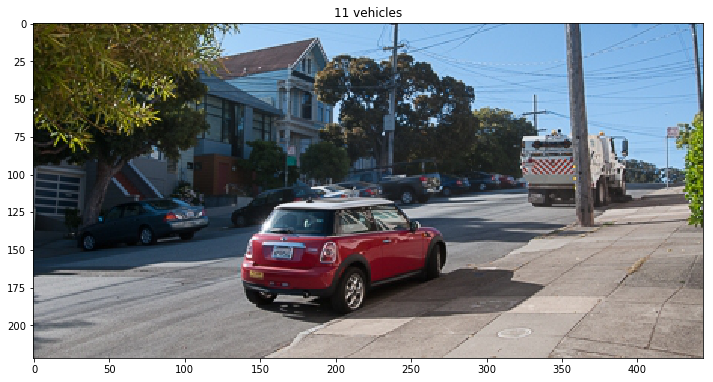

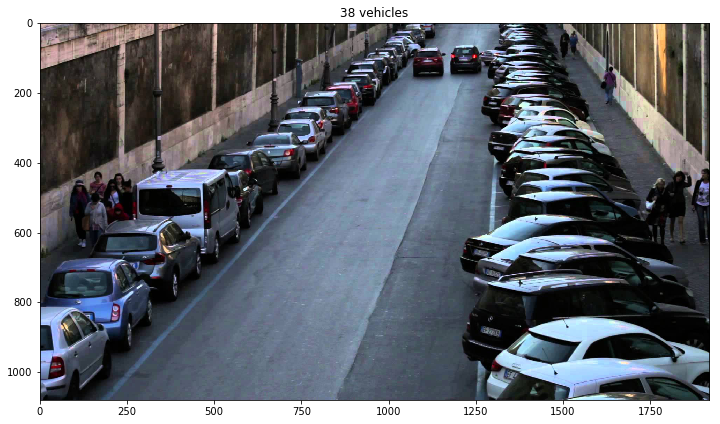

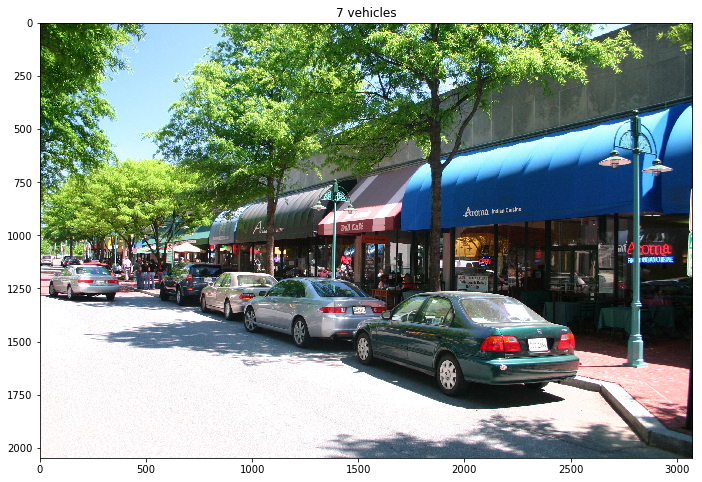

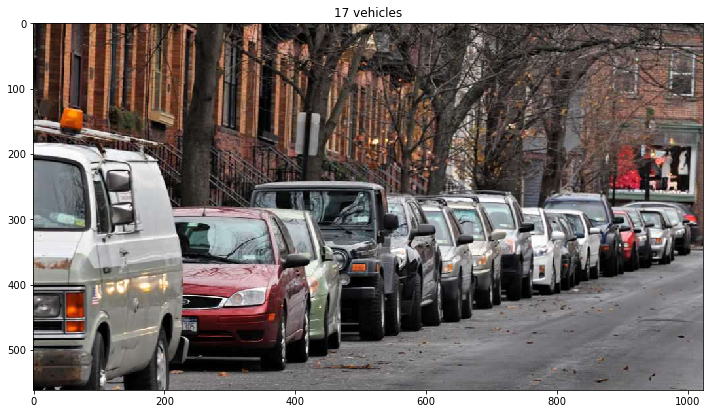

In [7]:
with detection_graph.as_default():
    with tf.Session(graph = detection_graph) as sess:
        for filename in [fn for fn in os.listdir('test_images') if fn[-4:] == '.jpg']:
            image             = Image.open('test_images/' + filename)
            image_np          = load_image_into_numpy_array(image)
            image_np_expanded = np.expand_dims(image_np, axis = 0)
            image_tensor      = detection_graph.get_tensor_by_name('image_tensor:0')
            boxes             = detection_graph.get_tensor_by_name('detection_boxes:0')
            scores            = detection_graph.get_tensor_by_name('detection_scores:0')
            classes           = detection_graph.get_tensor_by_name('detection_classes:0')
            num_detections    = detection_graph.get_tensor_by_name('num_detections:0')
            (boxes, scores, classes, num_detections) = sess.run(
                [boxes, scores, classes, num_detections], 
                feed_dict = {image_tensor: image_np_expanded})
            vehicle_number = result_to_vehicle_number(boxes.squeeze(), classes.squeeze(), scores.squeeze())
            plt.figure(figsize = (12, 8))
            plt.title('%d vehicles' % vehicle_number)
            plt.imshow(image_np)